#### 1. Segmentation

Segment the test entire test folder. 
Add the left ventricule labels
Create a new test set in ouput folder location where the segmentation is completed.

**This new segmentation folder will be use to extract feature so it is necessary to compute it.**
    

In [1]:
from segmentation import * 

In [2]:
BASE_DIR = os.getcwd()
TRAIN_DIR = os.path.join(BASE_DIR, "Dataset/Train")
TEST_DIR = os.path.join(BASE_DIR,"Dataset/Test")
SEGMENTED_TEST_DIR = os.path.join(BASE_DIR,"Dataset/SegTest") 
segment_and_save_test_set(TEST_DIR,SEGMENTED_TEST_DIR)

Segmented and saved: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/135/135_ES_seg.nii
Segmented and saved: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/135/135_ED_seg.nii
Copied original image: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/135/135_ED.nii
Copied original image: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/135/135_ES.nii
Copied original image: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/132/132_ES.nii
Copied original image: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/132/132_ED.nii
Segmented and saved: /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/SegTest/132/132_ED_seg.nii
Segmented and saved: /Users/rplanchon/Docu

#### 2 . Dataset Creation 
``Note : Derive from the pipeline_dataset.ipynb file``

In [3]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor
import itertools
import re


In [4]:
# Py-radiomics extractor that extract radiomic features.
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['normalize'] = True             # Z-score normalization
extractor.settings['normalizeScale'] = 100         # Stretch intensity to approx -300..+300
extractor.settings['removeOutliers'] = 3           # Clip extreme values beyond ±3σ
extractor.settings['voxelArrayShift'] = 300        # Shift to make intensities all positive

# === Discretization for texture ===
extractor.settings['binWidth'] = 5                 # Recommended for MRI after scaling

# === Resampling settings ===
extractor.settings['resampledPixelSpacing'] = [2, 2, 2]  # Isotropic 2mm resolution
extractor.settings['interpolator'] = 'sitkBSpline'       # Smooth interpolation for MRI

extractor.settings['additionalInfo'] = False
extractor.disableAllImageTypes()
extractor.enableImageTypeByName('Original')
extractor.disableAllFeatures()

# Feature que l'on veut : 
extractor.enableFeatureClassByName('shape') # Some shape features (volume, sphericity etc)
#extractor.enableFeatureClassByName('firstorder') # Some signal features
#extractor.enableFeatureClassByName("glcm")
#extractor.enableFeatureClassByName("glrlm")


In [5]:
# I just did that to be have clean folder depending on feature selected.
output_string = ""
for cls, feats in extractor.enabledFeatures.items():
    output_string += f"{cls}_" 
output_string += "features"
    

In [6]:
print(output_string)

shape_features


In [7]:
# TEST_DIR   = os.path.join(BASE_DIR, "Dataset", "SegTest")
OUT_DIR    = os.path.join(BASE_DIR, "data",output_string)
os.makedirs(OUT_DIR, exist_ok=True)

In [8]:
def extract_per_patient(folder, sid):
    rec = {"Id": sid}
    for ph in ["ED", "ES"]:
        img = sitk.ReadImage(os.path.join(folder, f"{sid}_{ph}.nii"))
        msk = sitk.ReadImage(os.path.join(folder, f"{sid}_{ph}_seg.nii"))
        for lbl,name in [(1,"RV"),(3,"LV"),(2,"MY")]:
            try:
                feats = extractor.execute(img, msk, label=lbl)
                for k,v in feats.items():
                    rec[f"{ph}_{name}_{k.replace('original_','')}"] = v
            except ValueError:
                # si jamais pas de label
                # avec nos donnés en pratique on passe jamais dedans.
                for k in extractor.enabledFeatures['shape']:
                    rec[f"{ph}_{name}_{k}"] = np.nan
    return rec

def all_patient(src_dir):
    # First i forgot to sort that lead to indexes problem
    patient_folders = sorted(
        [s for s in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, s))],
        key=lambda x: int(x)
    )

    # Extract features for each patient in the right order
    rows = [extract_per_patient(os.path.join(src_dir, s), s) for s in patient_folders]

    df = pd.DataFrame(rows)
    return df

def add_ratios(df,Train=True):
    
    # on récupère uniquement les features qui correspondent à des volume.
    # Dans les différents papiers la fractions d' ejection qui est un rapport revient souvent comme une feature importante. 
    # D'où l'idée de calculer différente ratio
    
    vol_cols = [c for c in df.columns if re.search(r'VoxelVolume$', c)]
    print(vol_cols)
    
    # on utilise combinations et pas product de itertools pour ne pas calculer A/B et B/A.
    # Car ce n'est pas très utile d'avoir des features redondantes comme ça
    ratio_frames = {}         

    for a,b in itertools.product(vol_cols, repeat = 2):
        if a != b :
            name = f"{a}_over_{b}"              
            ratio = np.divide(df[a], df[b])
            ratio_frames[name] = ratio

    # merge 
    df = pd.concat([df, pd.DataFrame(ratio_frames)], axis=1)

    return df
 

def compute_body_surface_area(height,weight): 
    "Return the body surface area from height and weight. (Formula of Du Bois)"
    
    return 0.007184 * (height**0.725 )* (weight**0.425)

def add_body_surface_area_feature(df : pd.DataFrame ,name_column_height = "Height",name_column_weight = "Weight"):
    # Add for each row the BSA associated.
    
    if (name_column_height and name_column_weight in df.columns) and ("body_surface" not in df.columns)  :
        df["body_surface"] = compute_body_surface_area(df[name_column_height],df[name_column_weight])
        #print("Body surface area feature added")
    else : 
        print("provide a dataframe with a height and weight feature")
       

def add_meta_data(df,Train= True):  
    if Train : 
        metaData = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTrain.csv"))
        metaData.drop(columns=["Category"],inplace=True)
        # print(metaData.head())
    else :
        metaData = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTest.csv"))
        # print(metaData.head())
    
    # I had some issues with int index as 001 can be translated to 1..
    # So I needed to ensure all Id have the same size by filling from the left 0s .
    df["Id"] = df["Id"].astype(str).str.zfill(3)  
    metaData["Id"] = metaData["Id"].astype(str).str.zfill(3)
    df = df.merge(metaData, on="Id", how="left")
    
    add_body_surface_area_feature(df)           
    df.drop(columns=["Height", "Weight"], errors="ignore", inplace=True)
    
    return df

In [9]:

df_train_all_features = all_patient(TRAIN_DIR)
df_test_all_features = all_patient(SEGMENTED_TEST_DIR)


df_train = add_ratios(df_train_all_features,Train=True)
df_test = add_ratios(df_test_all_features,Train=False)


df_train = add_meta_data(df_train,Train=True)
df_test = add_meta_data(df_test,Train=False)


NiftiImageIO (0x14df56ac0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED.nii has unexpected scales in sform

NiftiImageIO (0x14df56ac0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED.nii has unexpected scales in sform

NiftiImageIO (0x14dea8810): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x14dea8810): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x17e6156a0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ES.nii has unexpected scales in sform

NiftiImageIO (0x17e6156a0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ES.ni

['ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume', 'ES_LV_shape_VoxelVolume', 'ES_MY_shape_VoxelVolume']
['ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume', 'ES_LV_shape_VoxelVolume', 'ES_MY_shape_VoxelVolume']


In [10]:
# Création du label set
y = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTrain.csv"), usecols=["Id", "Category"])
y["Id"] = y["Id"].astype(str).str.zfill(3)  # Pour correspondre à dftrain

# Alignement de y 
y_aligned = y.set_index("Id").loc[df_train["Id"]].reset_index()

df_train.to_csv(os.path.join(OUT_DIR,"TrainningDataset.csv"), index=False)
df_test.to_csv(os.path.join(OUT_DIR,"TestingDataset.csv"), index=False)
y_aligned.to_csv(os.path.join(OUT_DIR,"TrainningDatasetCategory.csv"), index=False)


#### 3. Feature Selection/Reduction of Shape Feature

    Note this code is adjusted from pipeline_feature_selection.ipynb


In [11]:
import os 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier         
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif


In [12]:

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAINNING_DATASET = os.path.join(DATA_DIR,"TrainningDataset.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TESTING_DATASET = os.path.join(DATA_DIR,"TestingDataset.csv")


In [13]:
print(TRAINNING_DATASET)

/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/data/shape_features/TrainningDataset.csv


In [14]:
X = pd.read_csv(TRAINNING_DATASET)  # contient "Id"
y = pd.read_csv(LABEL_DIR)  # contient "Id" et "Category"

# S'assurer que les ID sont bien des chaînes formatées
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Aligner y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]


In [15]:
X_train = X.drop(columns=["Id"])


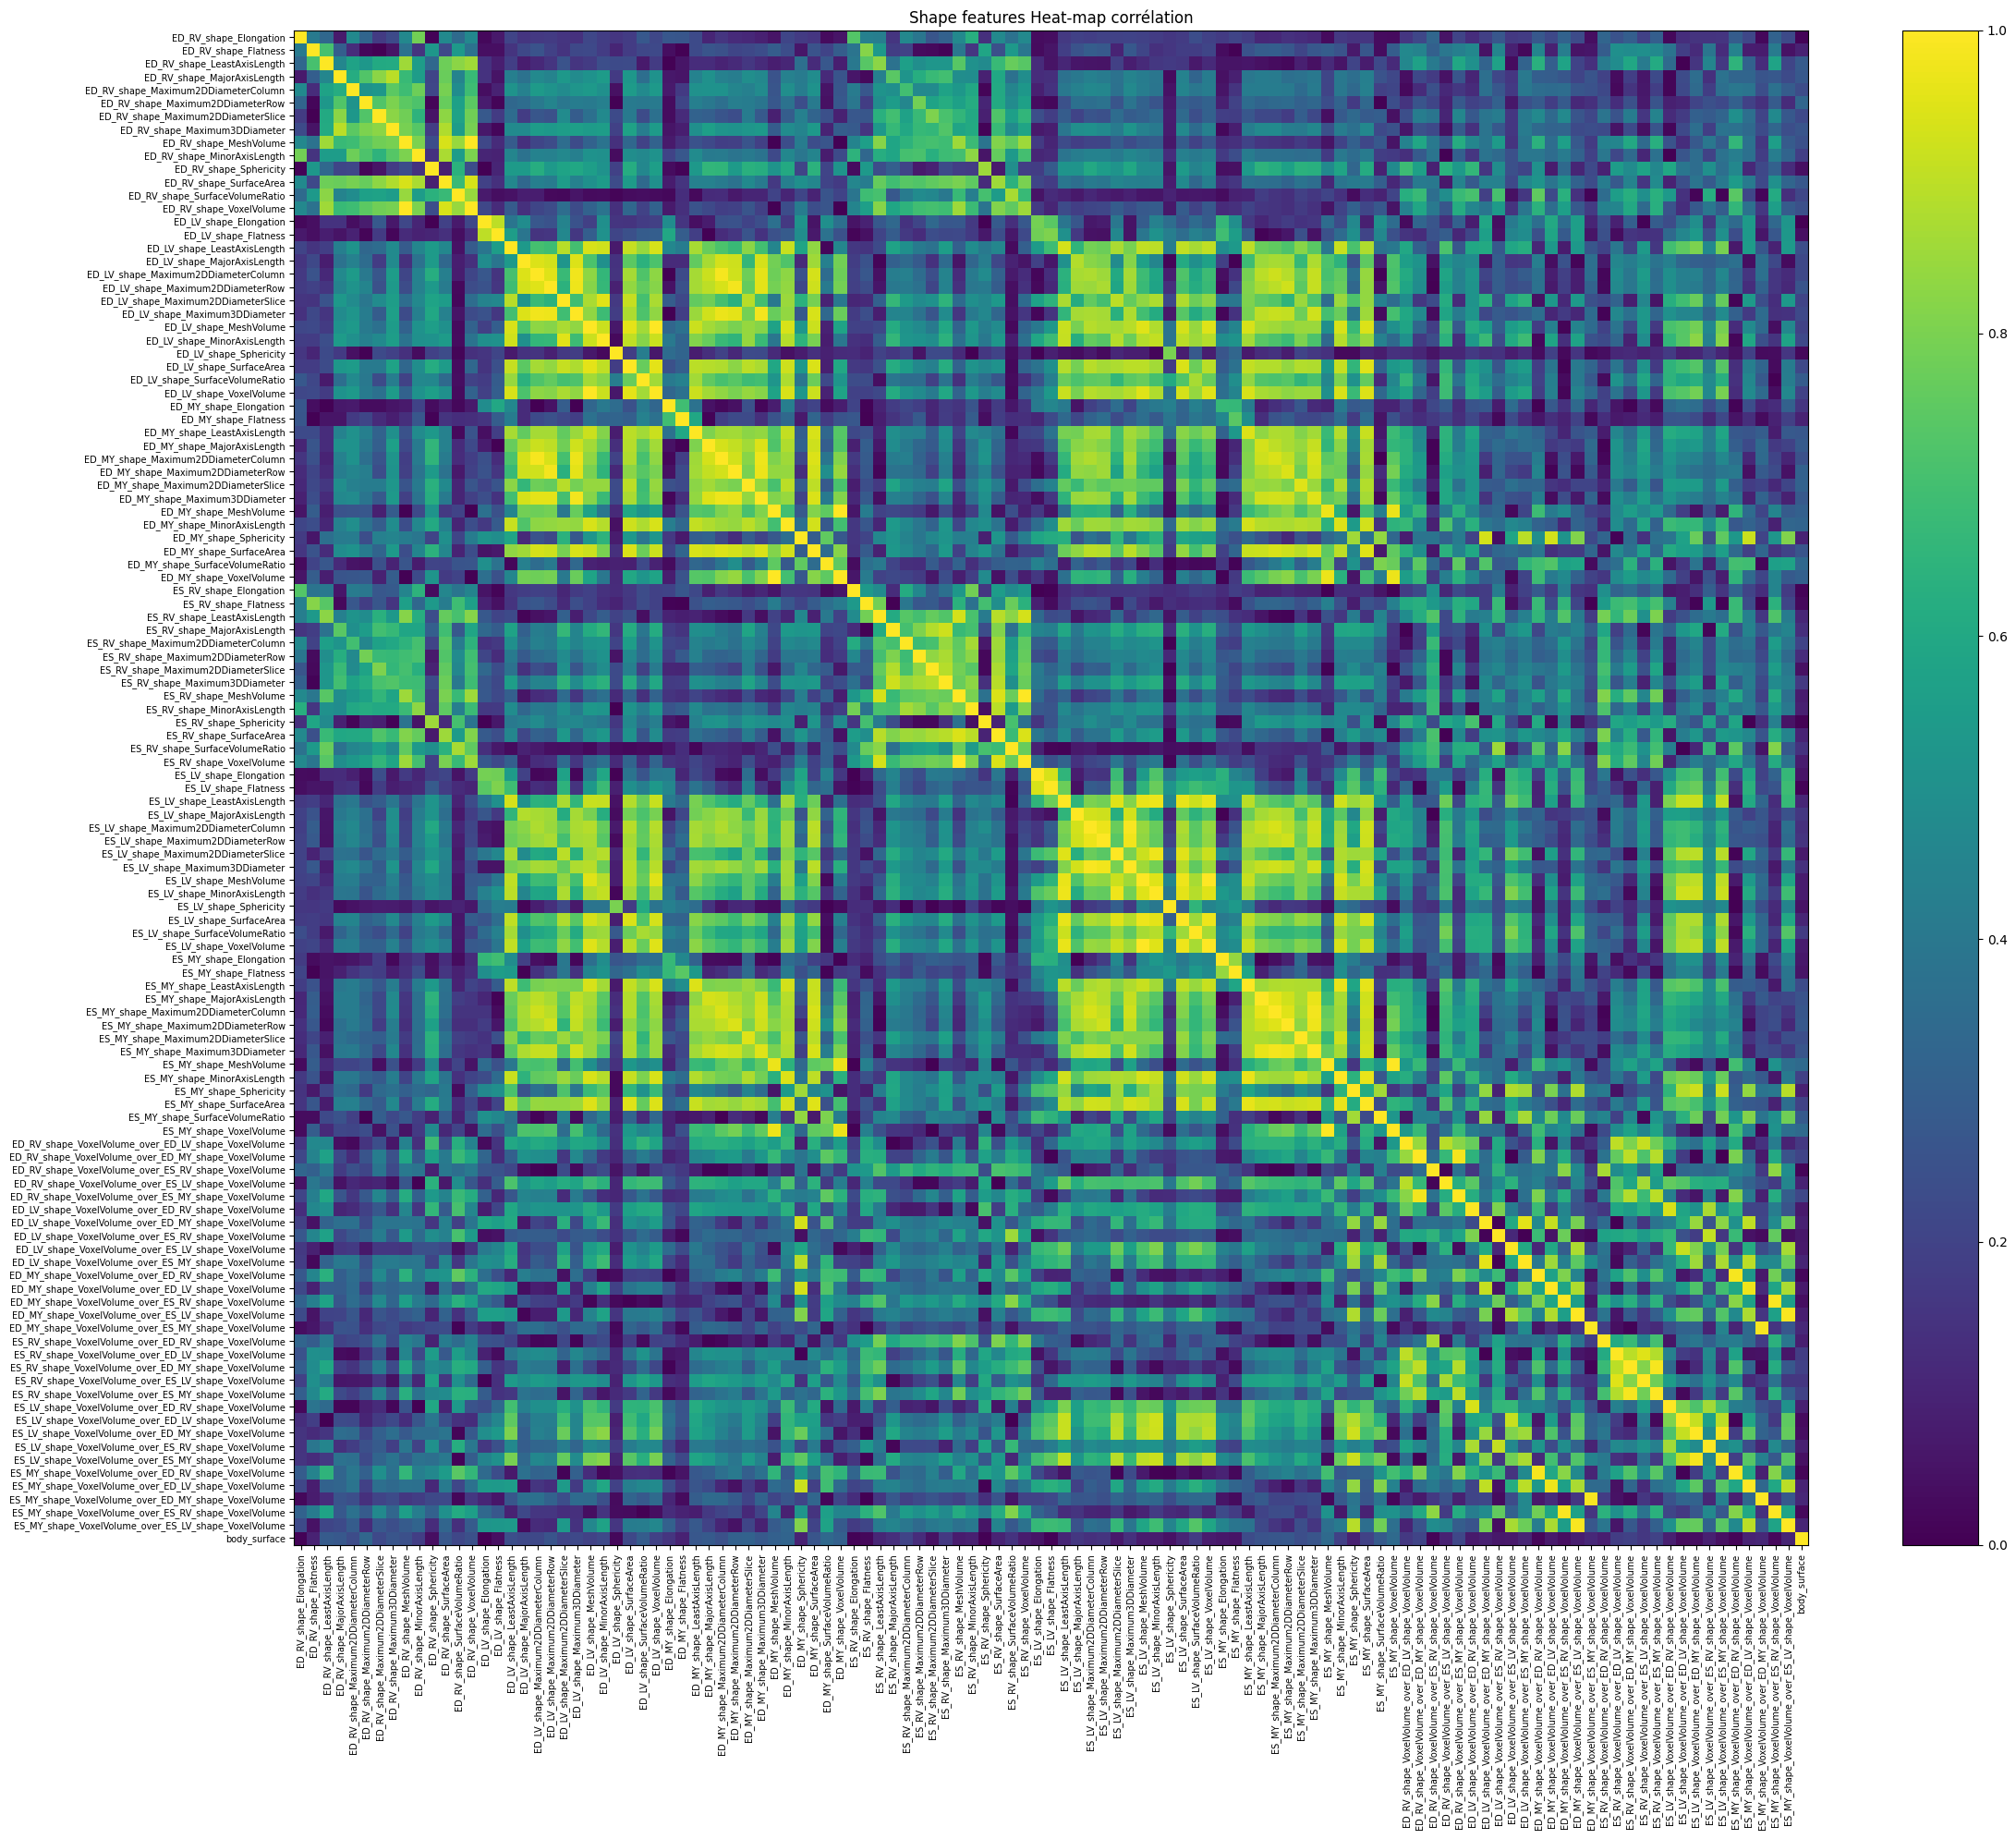

In [16]:
# Affichage de la Heat Map corrélation : on cherche à identifier les variables trop corrélés afin de les enlevés.
# En fonction du nombre de feature qu'on prend changer la figsize pour pouvoir voir.

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)


corr = scaled_features.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(26, 20))
cax = ax.imshow(abs(corr), vmin=0, vmax=1, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.columns, fontsize=7)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Shape features Heat-map corrélation")
plt.tight_layout()
#fig.savefig("heatmap_corr_glrlm_f.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()

/var/folders/cs/66ymsgmj2cl8m73sky0c22xw0000gn/T/ipykernel_2675/2162856499.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(1 - corr, method='average')


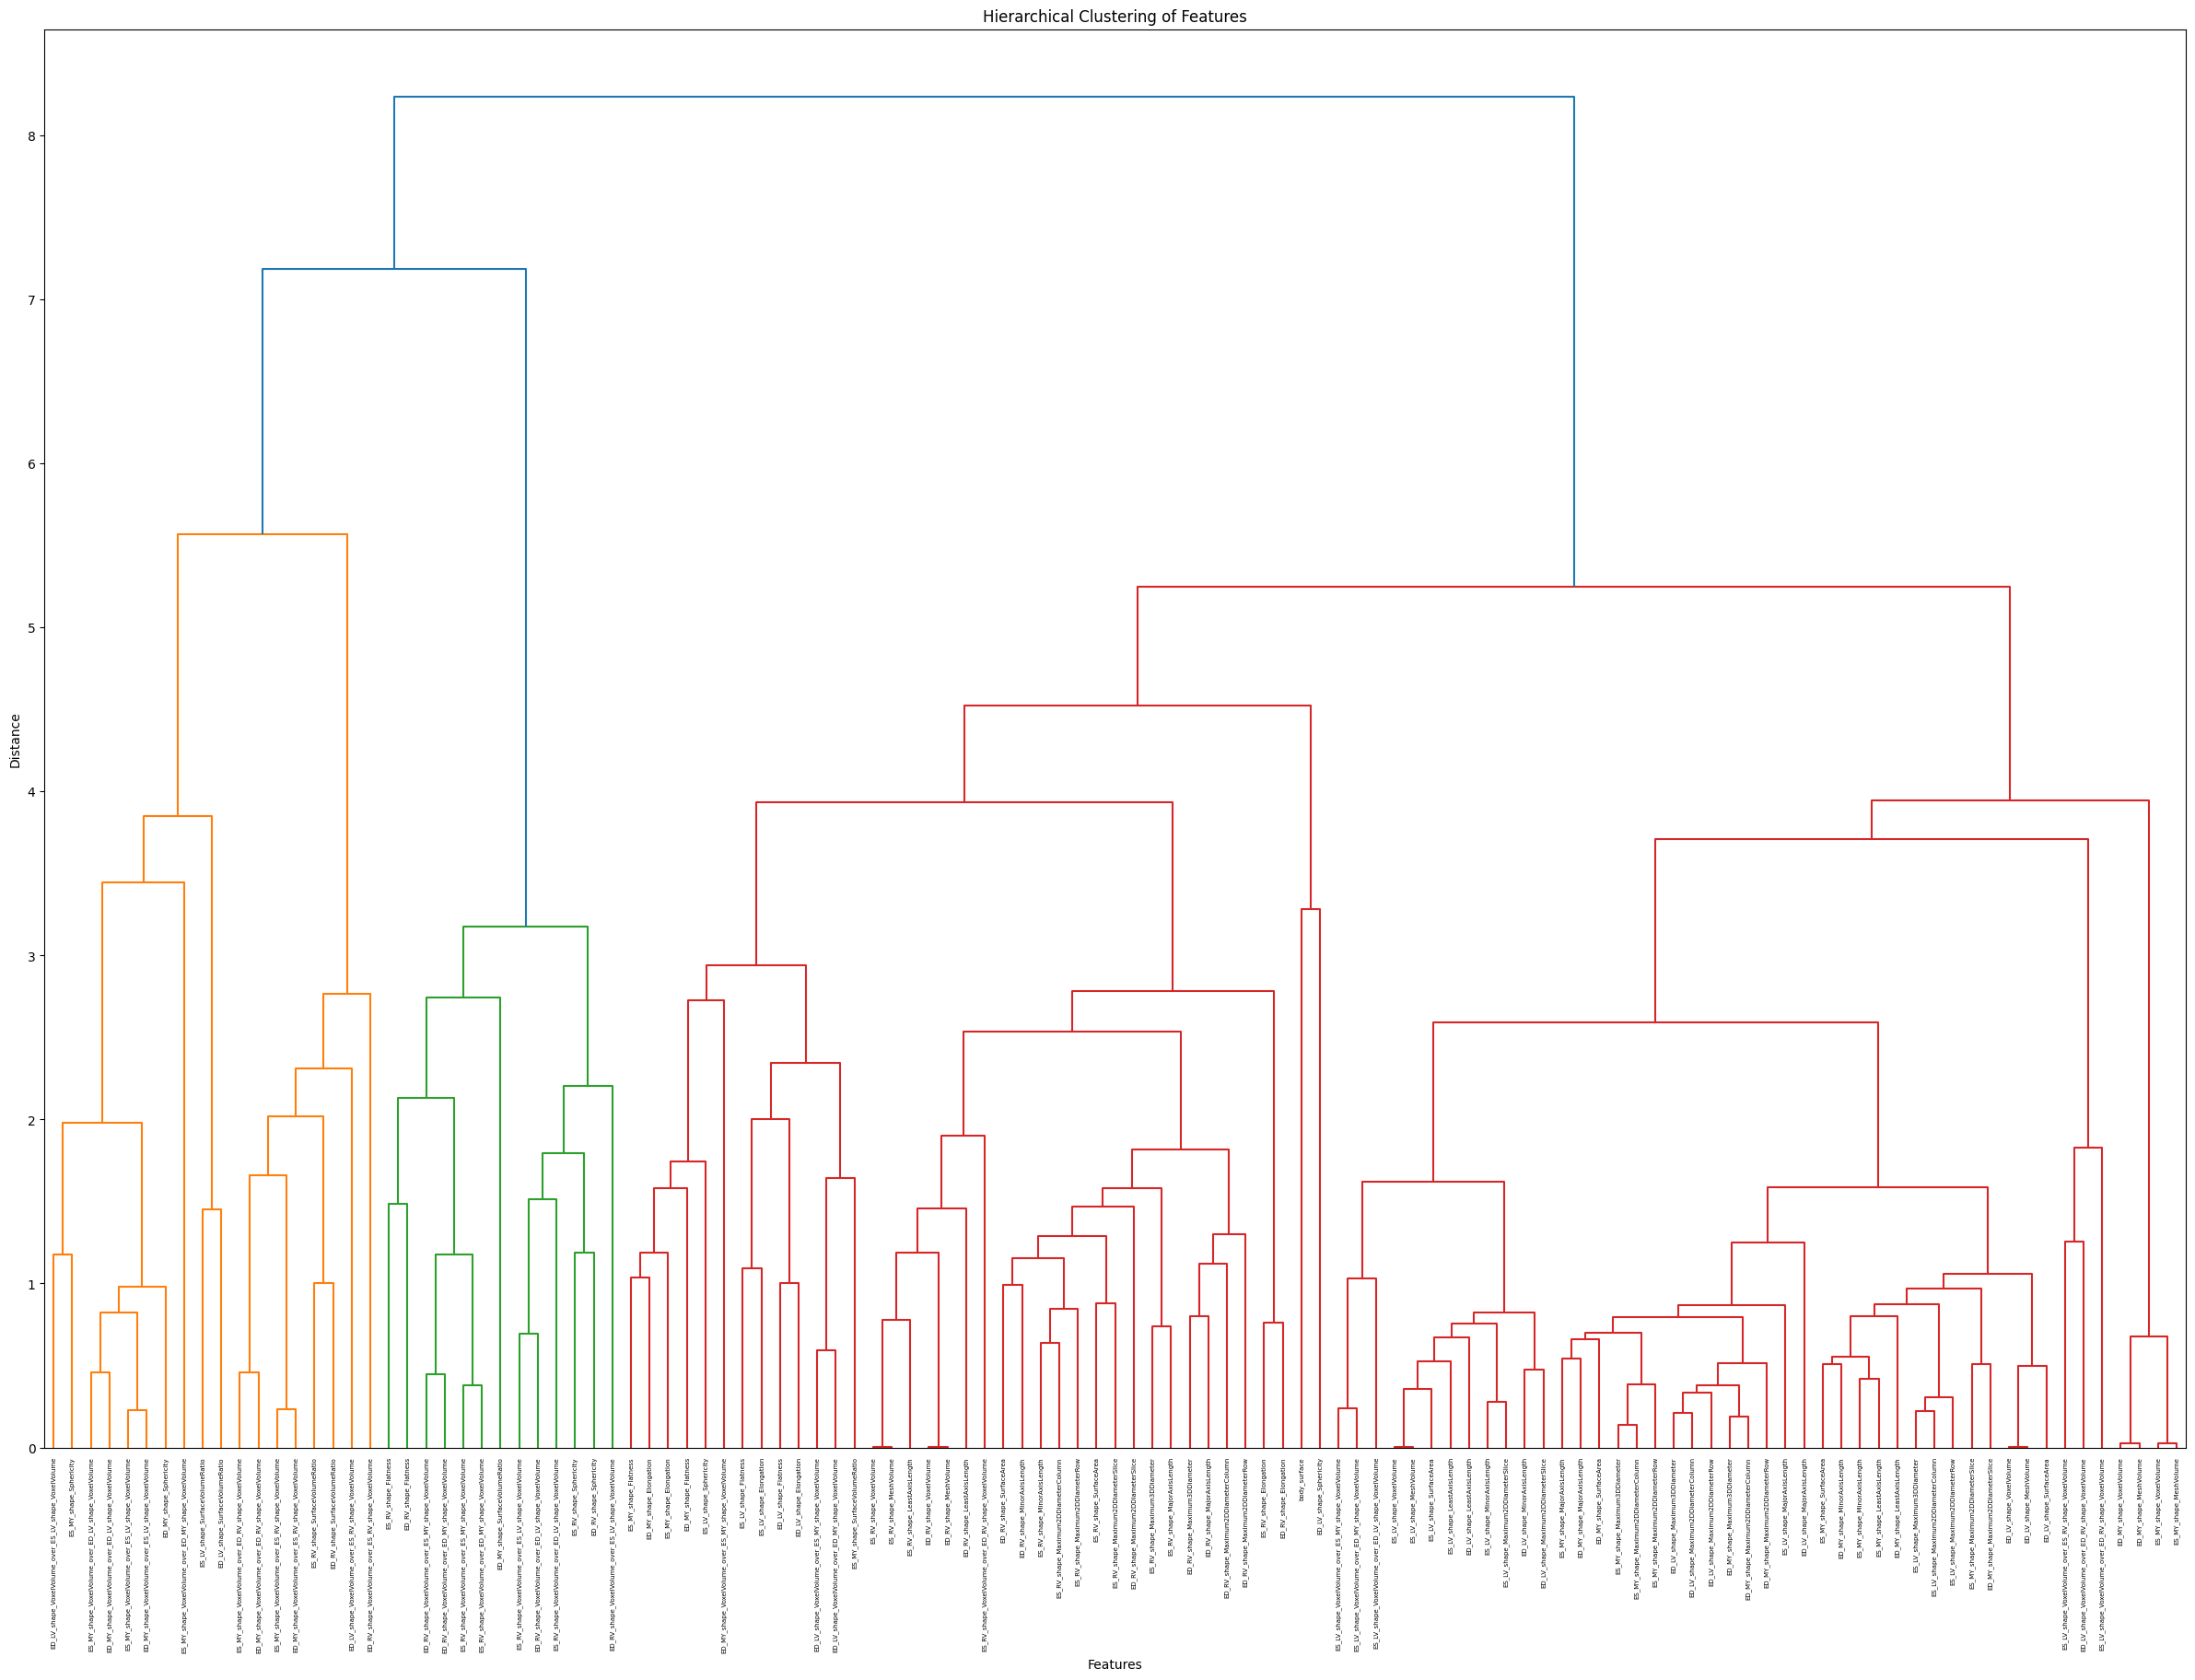

In [17]:
linkage_matrix = sch.linkage(1 - corr, method='average')


# We plot what is called a dendrogram to vizualize relationship between the different features.
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, labels=scaled_features.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering of Features")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [18]:
# On retire les features avec une Variance trop faible. Pour l'instant je supprime juste les features constantes.

var_sel = VarianceThreshold(threshold=1e-3)     
X1 = var_sel.fit_transform(X_train)
selected_var = X_train.columns[var_sel.get_support()]
print(f"Number of features removed bc of too small variance : {len(X_train.columns) - len(selected_var)}")


Number of features removed bc of too small variance : 2


In [19]:
T = 0.92
def drop_high_corr(df, threshold=0.9):
    c = df.corr(numeric_only=True).abs()
    upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X2_df, highly_corr = drop_high_corr(pd.DataFrame(X1, columns=selected_var), threshold=T)

print(f"Features retirées pour avec critère de corrélation > {T} : {len(highly_corr)}")
print(f"Nombre de features restantes : {X2_df.shape[1]}")


Features retirées pour avec critère de corrélation > 0.92 : 56
Nombre de features restantes : 57


In [20]:
selected_final = X2_df.columns.to_list()

pd.Series(selected_final).to_csv(os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"])

X_train_reduced = X[["Id"] + selected_final]


X_train_reduced.to_csv(os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False)

# use the same feature for the test set. 
# Ensure that the test set uses the same 'Id' as the training set

X_test = pd.read_csv(os.path.join(DATA_DIR,"TestingDataset.csv"))
X_test_reduced = pd.DataFrame(X_test,columns=X_train_reduced.columns)
X_test_reduced.to_csv(os.path.join(DATA_DIR, "TestingDataset_reduced.csv"), index=False)

### BASELINE MODEL 
(Just variance treshold + corr treshold on shape features)

In [21]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os

In [22]:
# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAINNING_DATASET_REDUCED = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TESTING_DATASET_REDUCED = os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [23]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv(TRAINNING_DATASET_REDUCED)
y = pd.read_csv(LABEL_DIR)
X_test = pd.read_csv(TESTING_DATASET_REDUCED)

# Assurez-vous que les identifiants sont bien formatés avec des zéros
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Mélange des lignes de X
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

# Réalignement parfait de y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]

# Séparation des features
X_train = X.drop(columns=["Id"])

X_test["Id"] = X_test["Id"].astype(str).str.zfill(3)
X_test = X_test.drop(columns=["Id"])


In [24]:
pipeline = ImbPipeline([ 
    ("normaliser" , MinMaxScaler()),                  
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'classifier', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [25]:
# Cross Validation
cv = StratifiedKFold(shuffle=True)

In [26]:
param_grid = {
    'classifier__n_estimators': [100,150,200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [5,6,None],
    'classifier__min_samples_leaf': [2,3,4],
}

In [27]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.950) total time=   0.1s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.950) total time=   0.1s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.950) total time=   0.1s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.950) total time=   0.1s
[CV 1/5] END classifier

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('normaliser', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, 6, None],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [2, 3, 4],
                         'classifier__n_estimators': [100, 150, 200]},
             return_train_score=True, verbose=3)

In [28]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100} 
score validation set : (0.96, 0.020000000000000018)
score trainning set : (1.0, 0.0)


In [29]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=2))], 'verbose': False, 'normaliser': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=2), 'normaliser__clip': False, 'normaliser__copy': True, 'normaliser__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 100, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': False}


In [30]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                                              feature  importance
50  ED_MY_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.060739
44  ED_RV_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.060416
36                     ES_LV_shape_SurfaceVolumeRatio    0.059772
53  ES_RV_shape_VoxelVolume_over_ED_LV_shape_Voxel...    0.053630
46  ED_LV_shape_VoxelVolume_over_ES_RV_shape_Voxel...    0.050631
47  ED_LV_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.048424
55  ES_LV_shape_VoxelVolume_over_ES_RV_shape_Voxel...    0.042121
13                        ED_LV_shape_LeastAxisLength    0.041180
41  ED_RV_shape_VoxelVolume_over_ED_LV_shape_Voxel...    0.040077
48  ED_MY_shape_VoxelVolume_over_ED_RV_shape_Voxel...    0.038185
49  ED_MY_shape_VoxelVolume_over_ES_RV_shape_Voxel...    0.038035
39                             ES_MY_shape_Sphericity    0.037346
42  ED_RV_shape_VoxelVolume_over_ED_MY_shape_Voxel...    0.035234
20                             ED_MY_shape_MeshVolume    0.032502
40        

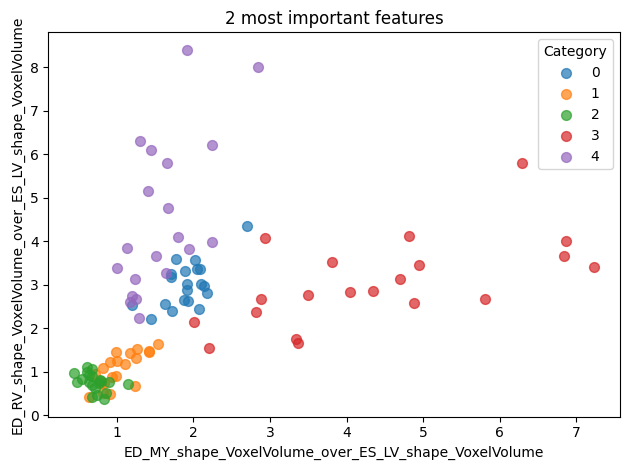

In [31]:
import matplotlib.pyplot as plt


df = X.copy()
df['Category'] = y["Category"]

fig, ax = plt.subplots()
for cat, sub in df.groupby('Category'):
    F = feature_importance[:]["feature"].to_list()
    F1,F2 = F[0],F[1]
    ax.scatter(sub[F1], sub[F2], label=cat, s=50, alpha=0.7)
ax.set_xlabel(F1)
ax.set_ylabel(F2)
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

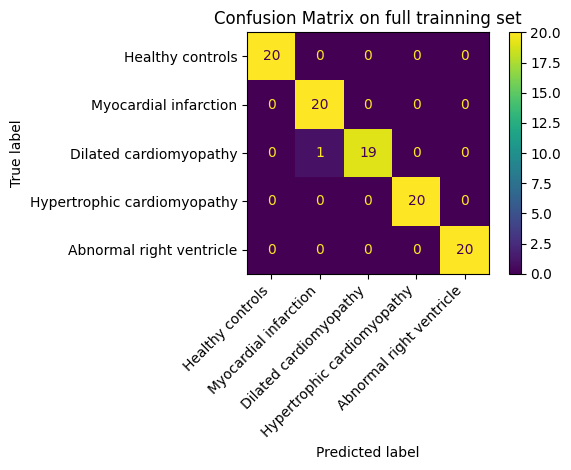

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [32]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X_train)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.savefig("conf_mat_baseline_model.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

print(classification_report(y_train,y_pred))

In [33]:
# Get the probabilities to get better insight on the model performance
proba = inf_pipeline.predict_proba(X_train)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")

# Goal of the function below : Find were the model is the most uncertain.

# Below is computed L
# L[1] and L[2] = 2 means that twice the model had a probaility >0.4 for both class 1 and class 2
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.7291285772517658

average margin score : 0.7825542192057279

[0, 1, 1, 0, 0]


#### 4. BASELINE MODEL WITH mRMR

``This is a copy of baseline_model.ipynb```

**IMPORTANT REMINDERS**
Verify that you have previously computed the trainningdataset associated with the features you want.
TrainningDataset are located in the folder `data` 

For instance `data/shape_glrlm_features` contains datasets with shape features as well as glrlm features.



In [34]:
import sklearn_mrmr.mrmr

N_features_to_select = 15

mrmr_sel = sklearn_mrmr.mrmr.MRMRFeatureSelector(n_features_to_select=N_features_to_select)
selected_final = list(mrmr_sel.fit_transform(X2_df, y_train).columns)


pd.Series(selected_final).to_csv(os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"])

X_train_reduced = X[["Id"] + selected_final]


X_train_reduced.to_csv(os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False)


# use the same feature for the test set. 
# Ensure that the test set uses the same 'Id' as the training set

X_test = pd.read_csv(os.path.join(DATA_DIR,"TestingDataset.csv"))
X_test_reduced = pd.DataFrame(X_test,columns=X_train_reduced.columns)
X_test_reduced.to_csv(os.path.join(DATA_DIR, "TestingDataset_reduced.csv"), index=False)

In [35]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os

In [36]:

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAINNING_DATASET_REDUCED = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TESTING_DATASET_REDUCED = os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [37]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv(TRAINNING_DATASET_REDUCED)
y = pd.read_csv(LABEL_DIR)
X_test = pd.read_csv(TESTING_DATASET_REDUCED)

# Assurez-vous que les identifiants sont bien formatés avec des zéros
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Mélange des lignes de X
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

# Réalignement parfait de y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]

# Séparation des features
X_train = X.drop(columns=["Id"])

X_test["Id"] = X_test["Id"].astype(str).str.zfill(3)
X_test = X_test.drop(columns=["Id"])


In [38]:
pipeline = ImbPipeline([ 
    ("normaliser" , MinMaxScaler()),                  
    ("classifier", RandomForestClassifier()),
])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'normaliser', 'classifier', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__monotonic_cst', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [39]:
# Cross Validation
cv = StratifiedKFold(shuffle=True)

In [40]:
param_grid = {
    'classifier__n_estimators': [100,150,200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth': [5,6,None],
    'classifier__min_samples_leaf': [2,3,4],
}

In [41]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.850) total time=   0.1s
[CV 2/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.650) total time=   0.1s
[CV 3/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.900) total time=   0.1s
[CV 4/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.900) total time=   0.1s
[CV 5/5] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_leaf=2, classifier__n_estimators=100;, score=(train=1.000, test=0.900) total time=   0.1s
[CV 1/5] END classifier

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('normaliser', MinMaxScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [5, 6, None],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [2, 3, 4],
                         'classifier__n_estimators': [100, 150, 200]},
             return_train_score=True, verbose=3)

In [42]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200} 
score validation set : (0.8699999999999999, 0.05099019513592783)
score trainning set : (0.9974999999999999, 0.004999999999999982)


Explication : Inference pipeline because before I had data augmentation

In [43]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('classifier', RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=200))], 'verbose': False, 'normaliser': MinMaxScaler(), 'classifier': RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=200), 'normaliser__clip': False, 'normaliser__copy': True, 'normaliser__feature_range': (0, 1), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__monotonic_cst': None, 'classifier__n_estimators': 200, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__wa

In [44]:
f_importance = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
f_name = grid_search.best_estimator_.named_steps["normaliser"].get_feature_names_out()
feature_importance = pd.DataFrame({
    "feature": f_name,
    "importance": f_importance
})
feature_importance.sort_values("importance", ascending=False, inplace=True)
print(feature_importance)

                                              feature  importance
13  ED_LV_shape_VoxelVolume_over_ES_LV_shape_Voxel...    0.186512
12  ED_MY_shape_VoxelVolume_over_ES_RV_shape_Voxel...    0.170832
11                             ES_MY_shape_Sphericity    0.119085
1                      ES_MY_shape_SurfaceVolumeRatio    0.090767
8   ED_RV_shape_VoxelVolume_over_ES_RV_shape_Voxel...    0.086087
2                      ED_MY_shape_SurfaceVolumeRatio    0.074888
9                              ED_MY_shape_Sphericity    0.071483
5                                ED_MY_shape_Flatness    0.036722
6                              ES_LV_shape_Elongation    0.033048
7                         ED_RV_shape_MinorAxisLength    0.032787
4                              ES_MY_shape_Elongation    0.026237
0                              ED_LV_shape_Sphericity    0.025523
3                              ED_RV_shape_Elongation    0.018441
10                             ED_LV_shape_Elongation    0.014218
14  ED_MY_

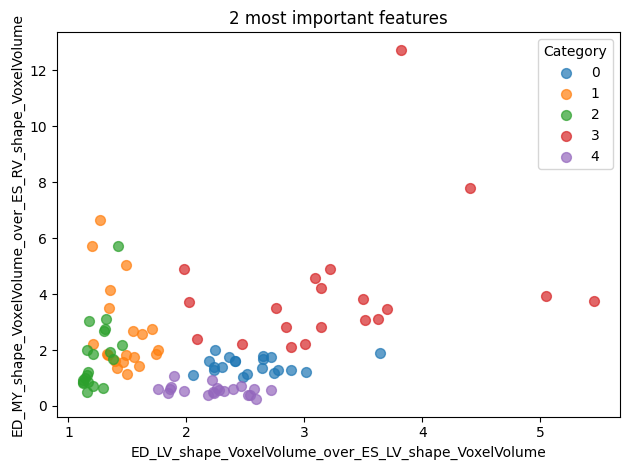

In [45]:
import matplotlib.pyplot as plt


df = X.copy()
df['Category'] = y["Category"]

fig, ax = plt.subplots()
for cat, sub in df.groupby('Category'):
    F = feature_importance[:]["feature"].to_list()
    F1,F2 = F[0],F[1]
    ax.scatter(sub[F1], sub[F2], label=cat, s=50, alpha=0.7)
ax.set_xlabel(F1)
ax.set_ylabel(F2)
ax.set_title('2 most important features')
ax.legend(title='Category')
plt.tight_layout()
plt.show()

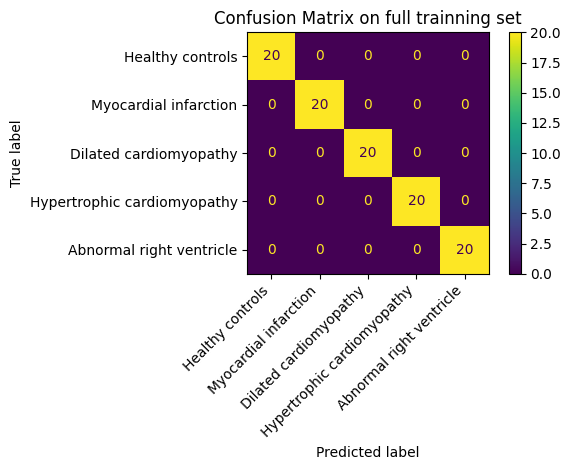

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [46]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X_train)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.savefig("conf_mat_baseline_model.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

print(classification_report(y_train,y_pred))

In [47]:
# Get the probabilities to get better insight on the model performance
proba = inf_pipeline.predict_proba(X_train)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")

# Goal of the function below : Find were the model is the most uncertain.

# Below is computed L
# L[1] and L[2] = 2 means that twice the model had a probaility >0.4 for both class 1 and class 2
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.6130521539415152

average margin score : 0.6826321484400453

[1, 1, 1, 1, 0]


#### SFE SVM on Radiomic Features

In [48]:
# Py-radiomics extractor that extract radiomic features.
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['normalize'] = True             # Z-score normalization
extractor.settings['normalizeScale'] = 100         # Stretch intensity to approx -300..+300
extractor.settings['removeOutliers'] = 3           # Clip extreme values beyond ±3σ
extractor.settings['voxelArrayShift'] = 300        # Shift to make intensities all positive

# === Discretization for texture ===
extractor.settings['binWidth'] = 5                 # Recommended for MRI after scaling

# === Resampling settings ===
extractor.settings['resampledPixelSpacing'] = [2, 2, 2]  # Isotropic 2mm resolution
extractor.settings['interpolator'] = 'sitkBSpline'       # Smooth interpolation for MRI

extractor.settings['additionalInfo'] = False
extractor.disableAllImageTypes()
extractor.enableImageTypeByName('Original')
extractor.disableAllFeatures()

# Feature que l'on veut : 
extractor.enableFeatureClassByName('shape') # Some shape features (volume, sphericity etc)
extractor.enableFeatureClassByName('firstorder') # Some signal features
extractor.enableFeatureClassByName("glcm")
extractor.enableFeatureClassByName("glrlm")


In [49]:
# I just did that to be have clean folder depending on feature selected.
output_string = ""
for cls, feats in extractor.enabledFeatures.items():
    output_string += f"{cls}_" 
output_string += "features"
    

In [50]:
print(output_string)

shape_firstorder_glcm_glrlm_features


In [51]:
# TEST_DIR   = os.path.join(BASE_DIR, "Dataset", "SegTest")
OUT_DIR    = os.path.join(BASE_DIR, "data",output_string)
os.makedirs(OUT_DIR, exist_ok=True)

In [52]:
def extract_per_patient(folder, sid):
    rec = {"Id": sid}
    for ph in ["ED", "ES"]:
        img = sitk.ReadImage(os.path.join(folder, f"{sid}_{ph}.nii"))
        msk = sitk.ReadImage(os.path.join(folder, f"{sid}_{ph}_seg.nii"))
        for lbl,name in [(1,"RV"),(3,"LV"),(2,"MY")]:
            try:
                feats = extractor.execute(img, msk, label=lbl)
                for k,v in feats.items():
                    rec[f"{ph}_{name}_{k.replace('original_','')}"] = v
            except ValueError:
                # si jamais pas de label
                # avec nos donnés en pratique on passe jamais dedans.
                for k in extractor.enabledFeatures['shape']:
                    rec[f"{ph}_{name}_{k}"] = np.nan
    return rec

def all_patient(src_dir):
    # First i forgot to sort that lead to indexes problem
    patient_folders = sorted(
        [s for s in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, s))],
        key=lambda x: int(x)
    )

    # Extract features for each patient in the right order
    rows = [extract_per_patient(os.path.join(src_dir, s), s) for s in patient_folders]

    df = pd.DataFrame(rows)
    return df

def add_ratios(df,Train=True):
    
    # on récupère uniquement les features qui correspondent à des volume.
    # Dans les différents papiers la fractions d' ejection qui est un rapport revient souvent comme une feature importante. 
    # D'où l'idée de calculer différente ratio
    
    vol_cols = [c for c in df.columns if re.search(r'VoxelVolume$', c)]
    print(vol_cols)
    
    # on utilise combinations et pas product de itertools pour ne pas calculer A/B et B/A.
    # Car ce n'est pas très utile d'avoir des features redondantes comme ça
    ratio_frames = {}         

    for a,b in itertools.product(vol_cols, repeat = 2):
        if a != b :
            name = f"{a}_over_{b}"              
            ratio = np.divide(df[a], df[b])
            ratio_frames[name] = ratio

    # merge 
    df = pd.concat([df, pd.DataFrame(ratio_frames)], axis=1)

    return df
 

def compute_body_surface_area(height,weight): 
    "Return the body surface area from height and weight. (Formula of Du Bois)"
    
    return 0.007184 * (height**0.725 )* (weight**0.425)

def add_body_surface_area_feature(df : pd.DataFrame ,name_column_height = "Height",name_column_weight = "Weight"):
    # Add for each row the BSA associated.
    
    if (name_column_height and name_column_weight in df.columns) and ("body_surface" not in df.columns)  :
        df["body_surface"] = compute_body_surface_area(df[name_column_height],df[name_column_weight])
        #print("Body surface area feature added")
    else : 
        print("provide a dataframe with a height and weight feature")
       

def add_meta_data(df,Train= True):  
    if Train : 
        metaData = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTrain.csv"))
        metaData.drop(columns=["Category"],inplace=True)
        # print(metaData.head())
    else :
        metaData = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTest.csv"))
        # print(metaData.head())
    
    # I had some issues with int index as 001 can be translated to 1..
    # So I needed to ensure all Id have the same size by filling from the left 0s .
    df["Id"] = df["Id"].astype(str).str.zfill(3)  
    metaData["Id"] = metaData["Id"].astype(str).str.zfill(3)
    df = df.merge(metaData, on="Id", how="left")
    
    add_body_surface_area_feature(df)           
    df.drop(columns=["Height", "Weight"], errors="ignore", inplace=True)
    
    return df

In [53]:

df_train_all_features = all_patient(TRAIN_DIR)
df_test_all_features = all_patient(SEGMENTED_TEST_DIR)


df_train = add_ratios(df_train_all_features,Train=True)
df_test = add_ratios(df_test_all_features,Train=False)


df_train = add_meta_data(df_train,Train=True)
df_test = add_meta_data(df_test,Train=False)


NiftiImageIO (0x14ec74330): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED.nii has unexpected scales in sform

NiftiImageIO (0x14ec74330): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED.nii has unexpected scales in sform

NiftiImageIO (0x14dec12d0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED_seg.nii has unexpected scales in sform

NiftiImageIO (0x14dec12d0): /Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/Dataset/Train/001/001_ED_seg.nii has unexpected scales in sform

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
NiftiImageIO (0x14e9bd3b0)

['ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume', 'ES_LV_shape_VoxelVolume', 'ES_MY_shape_VoxelVolume']
['ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume', 'ES_LV_shape_VoxelVolume', 'ES_MY_shape_VoxelVolume']


In [54]:
# Création du label set
y = pd.read_csv(os.path.join(BASE_DIR,"Dataset","metaDataTrain.csv"), usecols=["Id", "Category"])
y["Id"] = y["Id"].astype(str).str.zfill(3)  # Pour correspondre à dftrain

# Alignement de y 
y_aligned = y.set_index("Id").loc[df_train["Id"]].reset_index()

df_train.to_csv(os.path.join(OUT_DIR,"TrainningDataset.csv"), index=False)
df_test.to_csv(os.path.join(OUT_DIR,"TestingDataset.csv"), index=False)
y_aligned.to_csv(os.path.join(OUT_DIR,"TrainningDatasetCategory.csv"), index=False)


In [55]:

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAINNING_DATASET = os.path.join(DATA_DIR,"TrainningDataset.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TESTING_DATASET = os.path.join(DATA_DIR,"TestingDataset.csv")


In [56]:
print(TRAINNING_DATASET)

/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/data/shape_features/TrainningDataset.csv


In [57]:
X = pd.read_csv(TRAINNING_DATASET)  # contient "Id"
y = pd.read_csv(LABEL_DIR)  # contient "Id" et "Category"

# S'assurer que les ID sont bien des chaînes formatées
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Aligner y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]


In [58]:
X_train = X.drop(columns=["Id"])


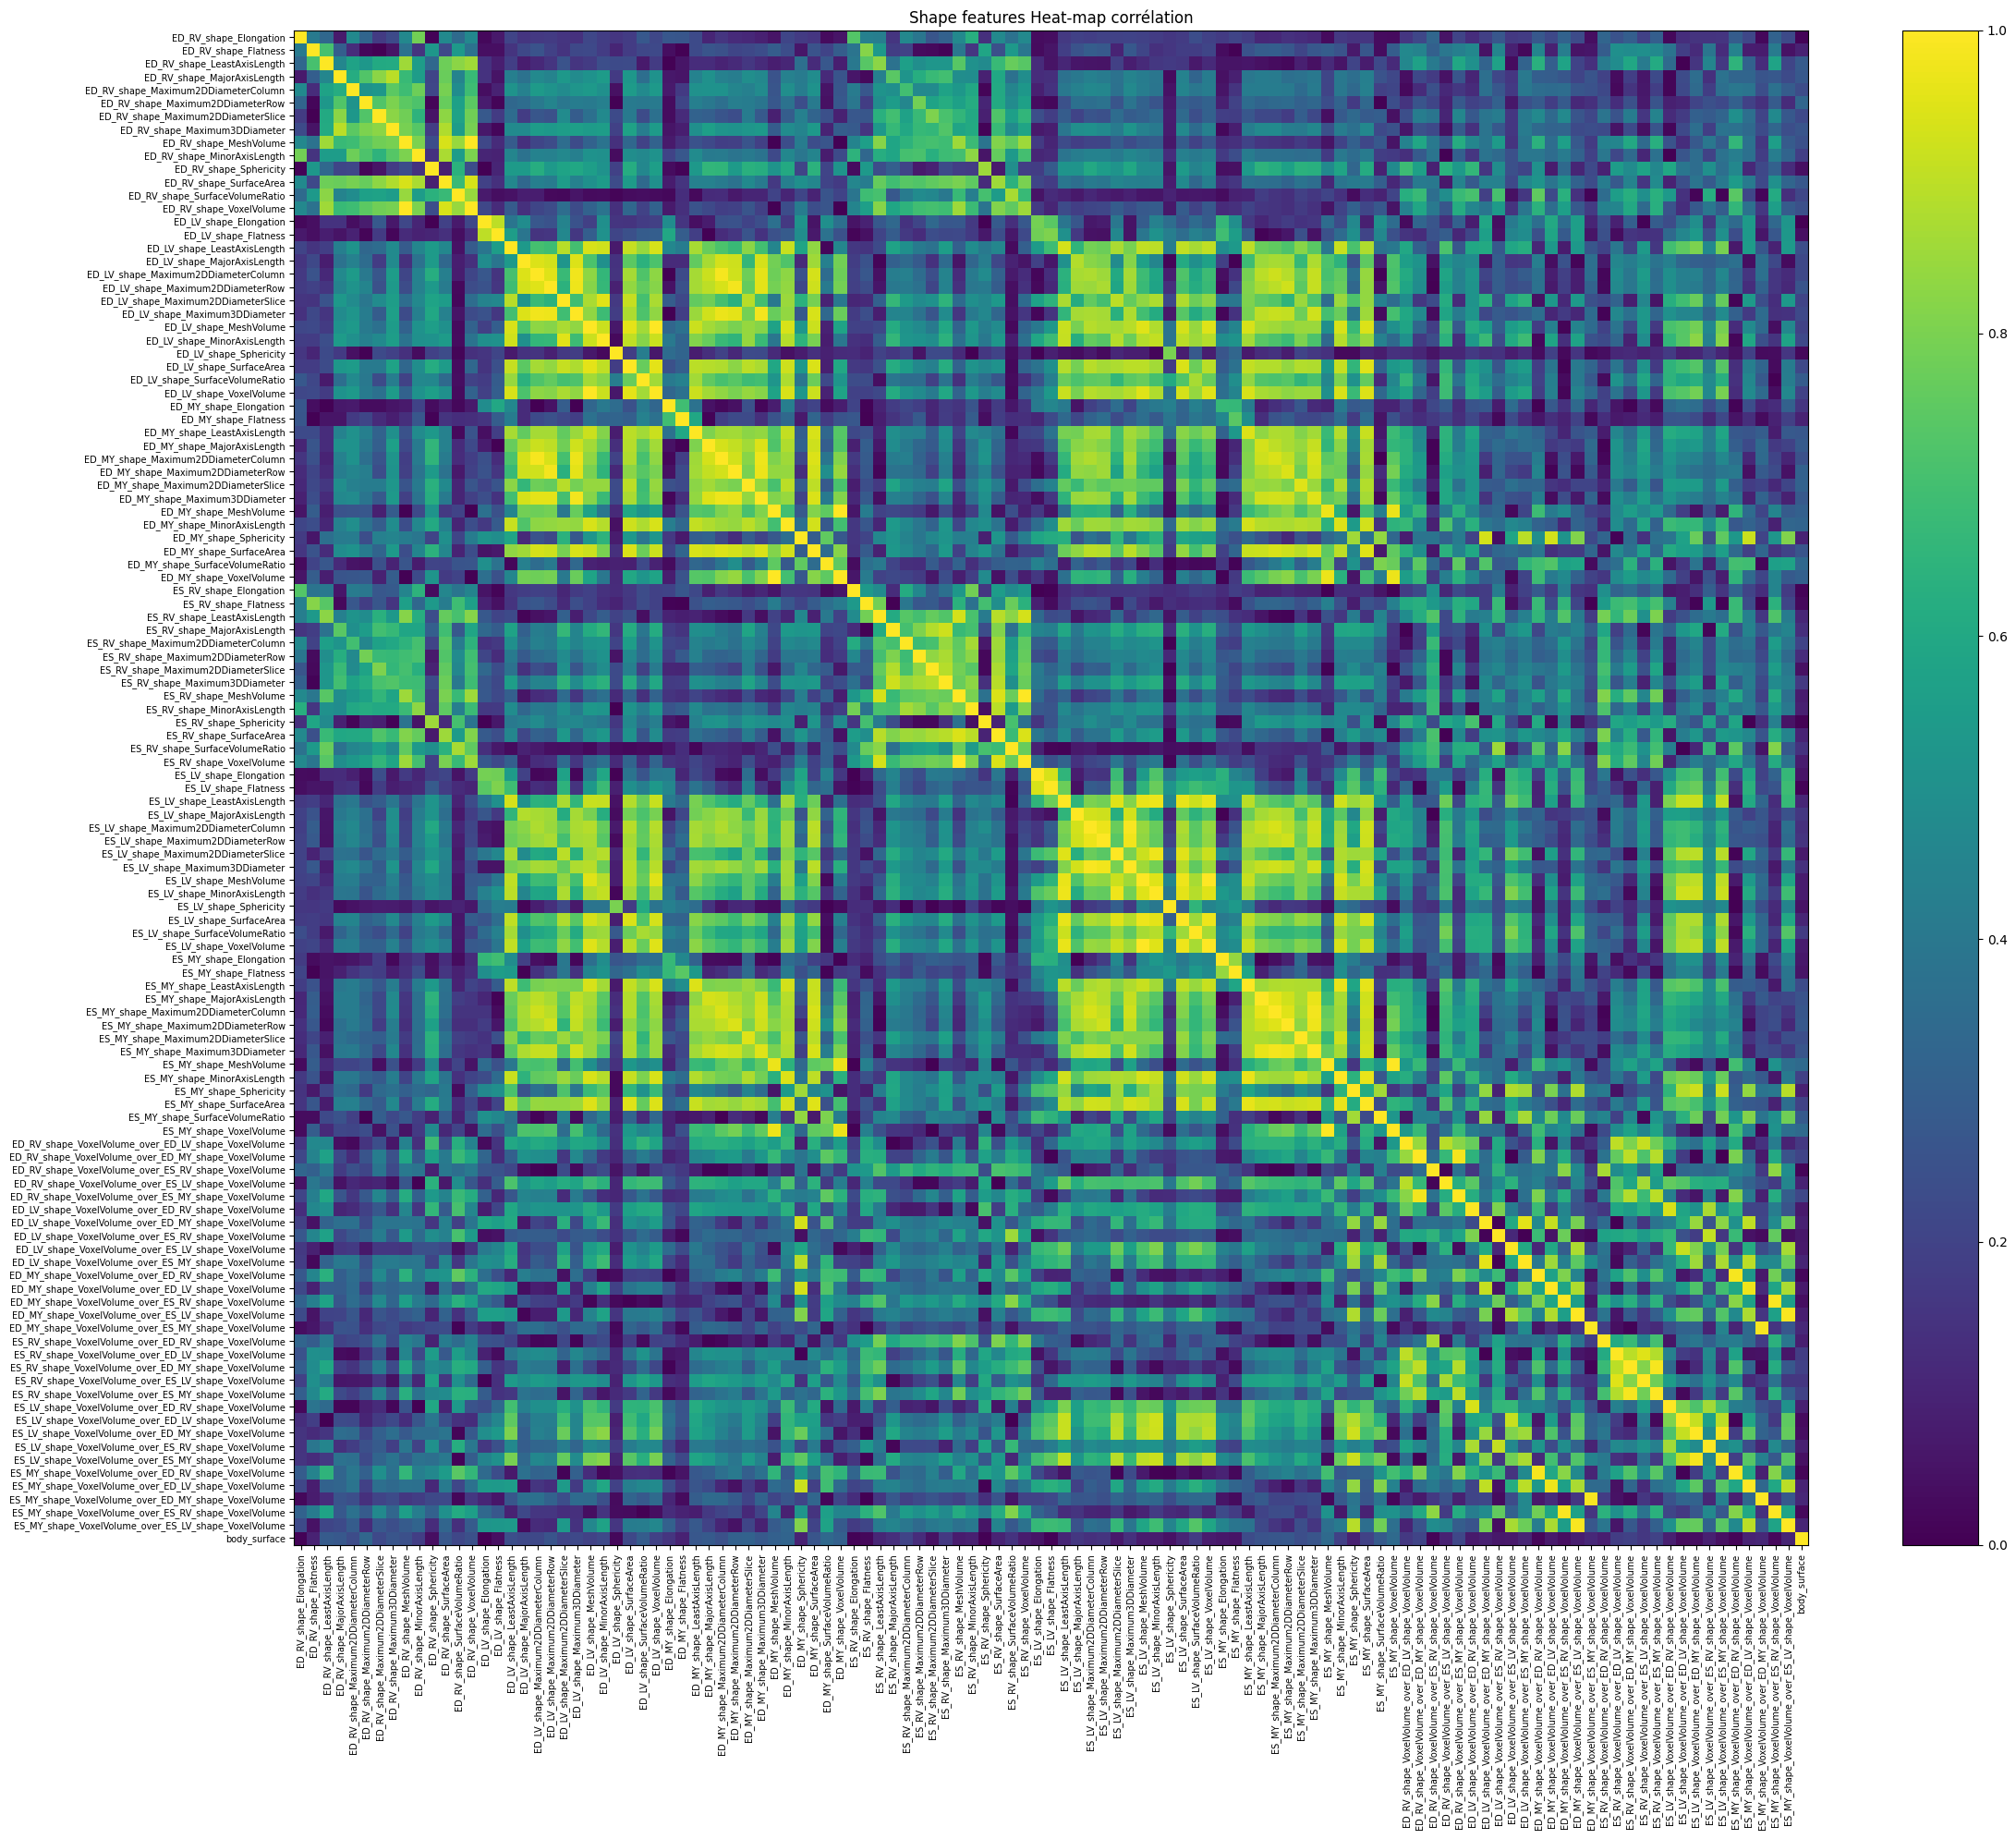

In [59]:
# Affichage de la Heat Map corrélation : on cherche à identifier les variables trop corrélés afin de les enlevés.
# En fonction du nombre de feature qu'on prend changer la figsize pour pouvoir voir.

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)


corr = scaled_features.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(26, 20))
cax = ax.imshow(abs(corr), vmin=0, vmax=1, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.columns, fontsize=7)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Shape features Heat-map corrélation")
plt.tight_layout()
#fig.savefig("heatmap_corr_glrlm_f.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()

/var/folders/cs/66ymsgmj2cl8m73sky0c22xw0000gn/T/ipykernel_2675/2162856499.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(1 - corr, method='average')


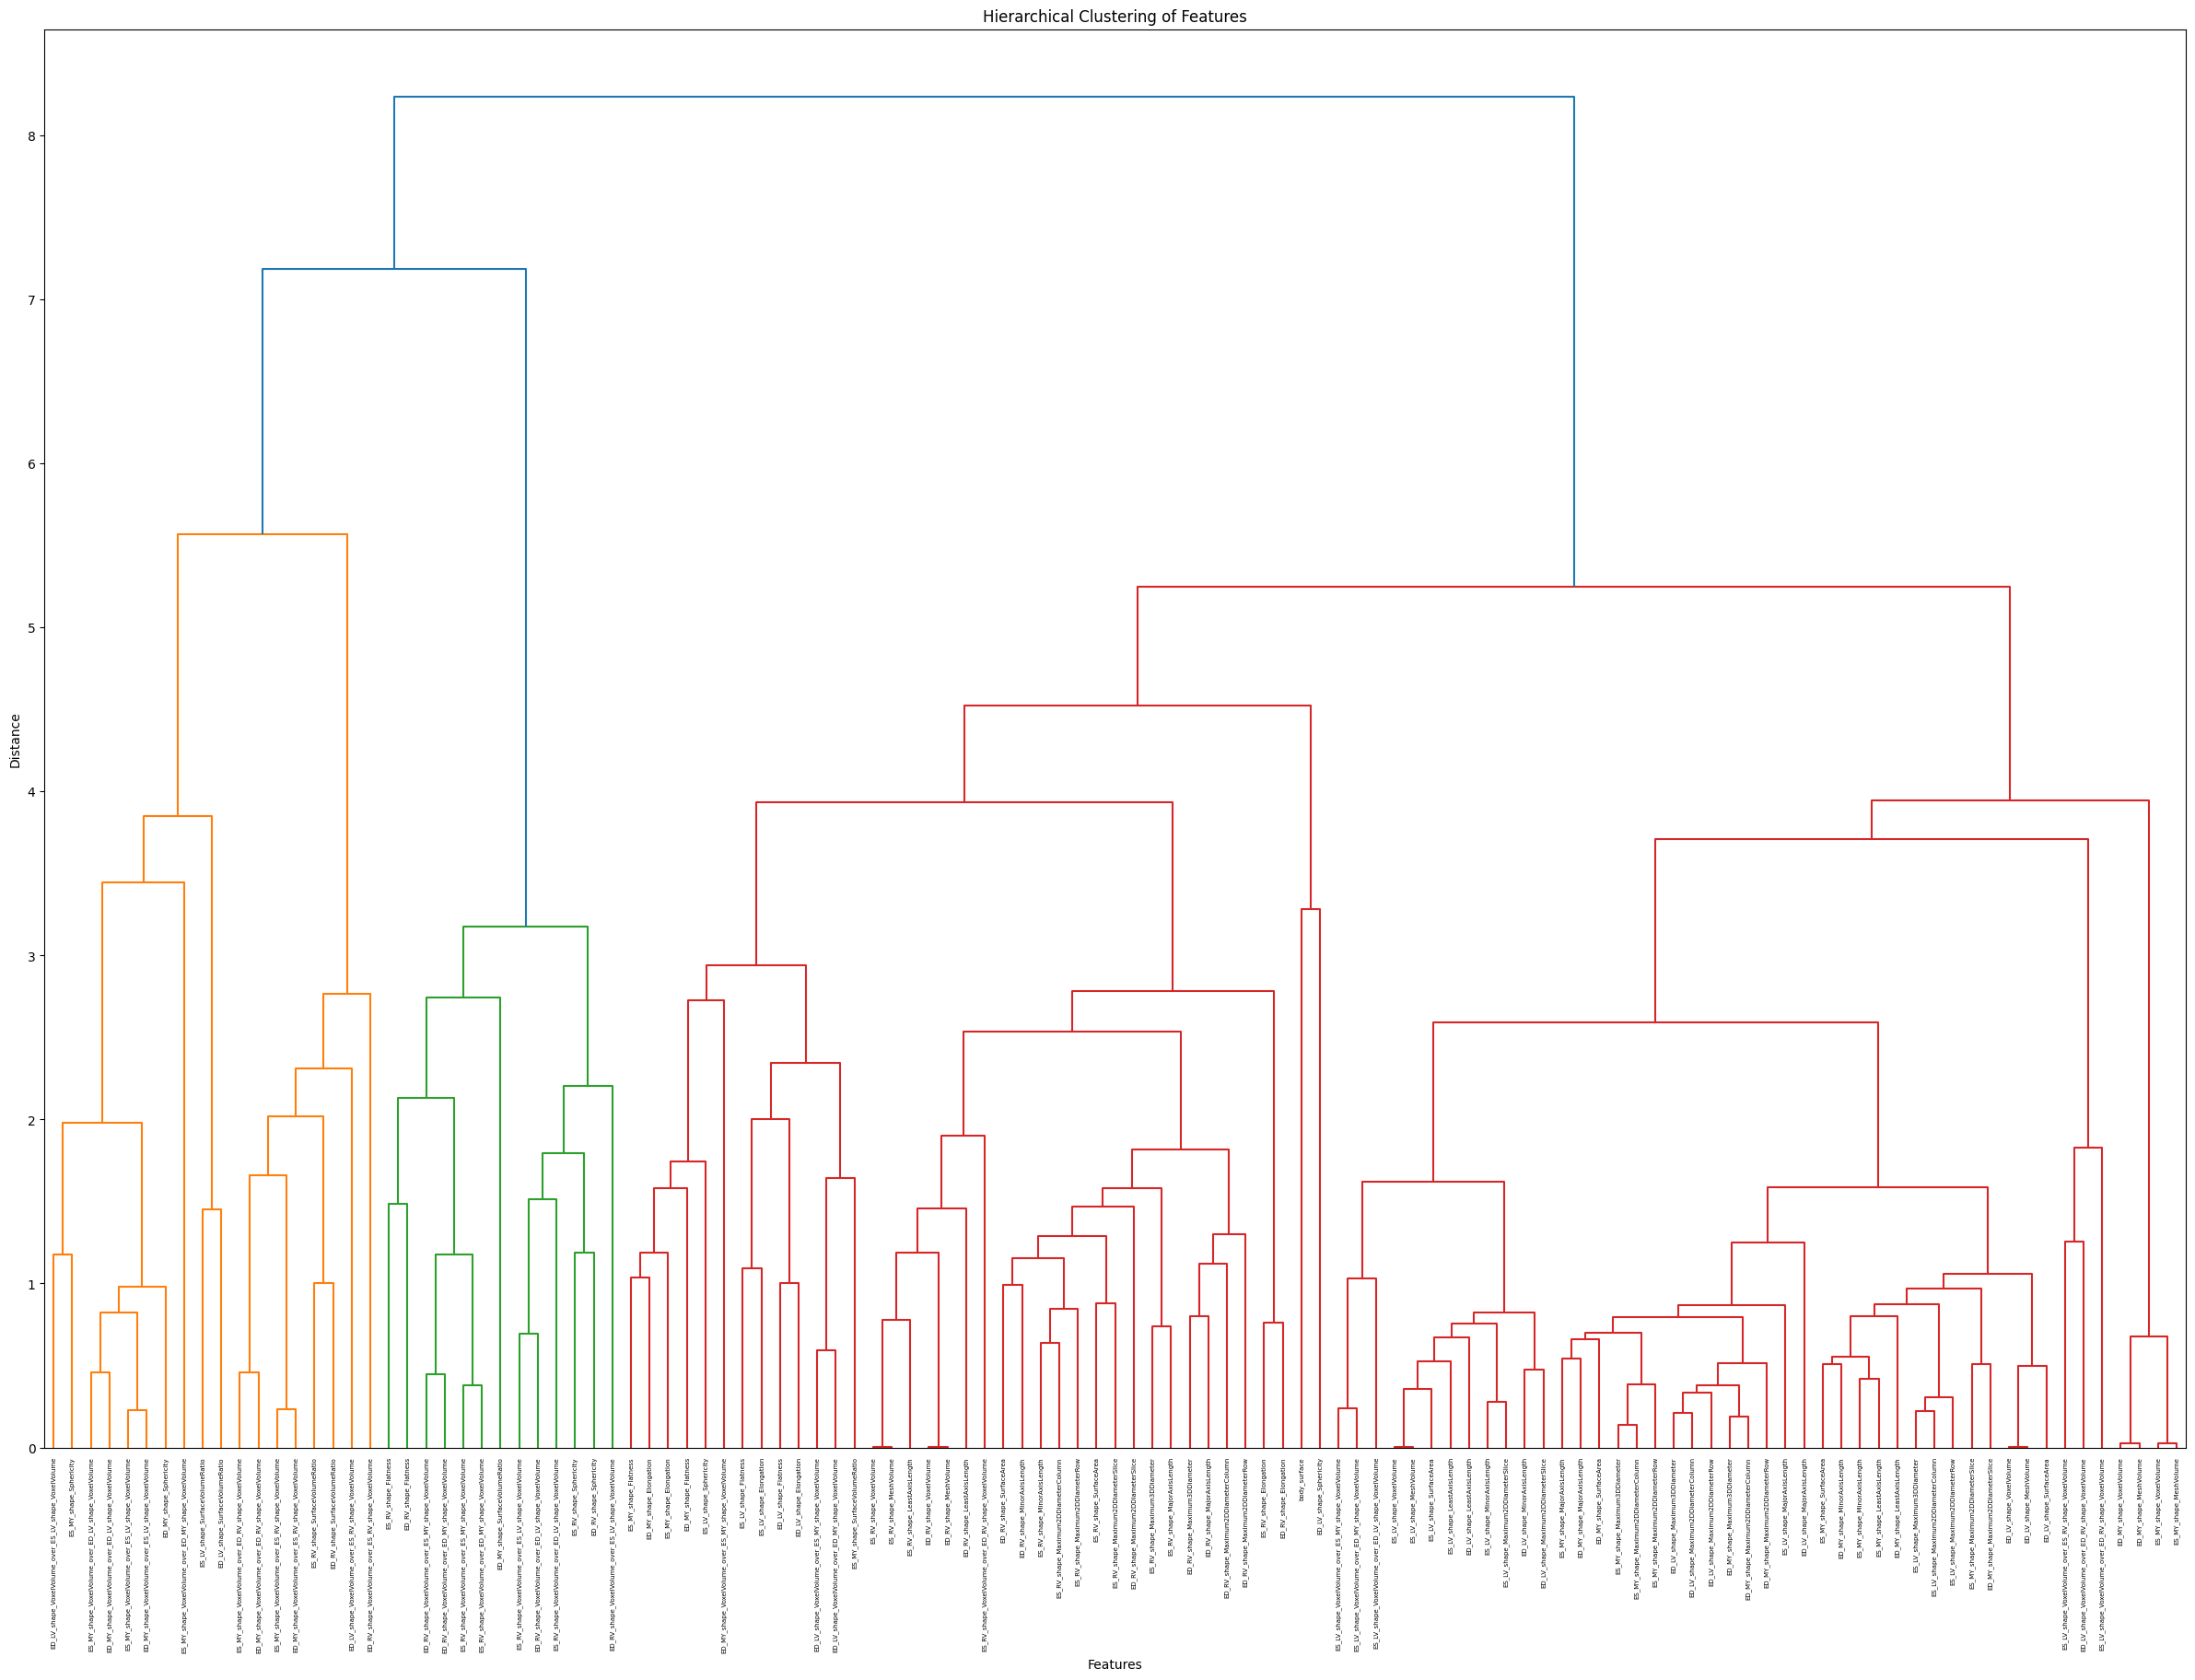

In [60]:
linkage_matrix = sch.linkage(1 - corr, method='average')


# We plot what is called a dendrogram to vizualize relationship between the different features.
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, labels=scaled_features.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering of Features")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [61]:
# On retire les features avec une Variance trop faible. Pour l'instant je supprime juste les features constantes.

var_sel = VarianceThreshold(threshold=1e-3)     
X1 = var_sel.fit_transform(X_train)
selected_var = X_train.columns[var_sel.get_support()]
print(f"Number of features removed bc of too small variance : {len(X_train.columns) - len(selected_var)}")


Number of features removed bc of too small variance : 2


In [62]:
T = 0.92
def drop_high_corr(df, threshold=0.9):
    c = df.corr(numeric_only=True).abs()
    upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X2_df, highly_corr = drop_high_corr(pd.DataFrame(X1, columns=selected_var), threshold=T)

print(f"Features retirées pour avec critère de corrélation > {T} : {len(highly_corr)}")
print(f"Nombre de features restantes : {X2_df.shape[1]}")


Features retirées pour avec critère de corrélation > 0.92 : 56
Nombre de features restantes : 57


In [63]:
import sklearn_mrmr.mrmr

N_features_to_select = 50

mrmr_sel = sklearn_mrmr.mrmr.MRMRFeatureSelector(n_features_to_select=N_features_to_select)
selected_final = list(mrmr_sel.fit_transform(X2_df, y_train).columns)


pd.Series(selected_final).to_csv(os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"])

X_train_reduced = X[["Id"] + selected_final]


X_train_reduced.to_csv(os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False)


# use the same feature for the test set. 
# Ensure that the test set uses the same 'Id' as the training set

X_test = pd.read_csv(os.path.join(DATA_DIR,"TestingDataset.csv"))
X_test_reduced = pd.DataFrame(X_test,columns=X_train_reduced.columns)
X_test_reduced.to_csv(os.path.join(DATA_DIR, "TestingDataset_reduced.csv"), index=False)

In [64]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from utils_pipeline import *
from utils_evaluate import *
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
import os
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt


In [65]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = output_string
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAINNING_DATASET_REDUCED_1 = os.path.join(DATA_DIR,"TrainningDataset_reduced.csv")
LABEL_DIR_1 = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TESTING_DATASET_REDUCED_1= os.path.join(DATA_DIR,"TestingDataset_reduced.csv")


In [66]:
# X contain basic features, volumes and border of each segmentation as well as weight and age of each person.
X = pd.read_csv(TRAINNING_DATASET_REDUCED_1)
y = pd.read_csv(LABEL_DIR_1)
X_test = pd.read_csv(TESTING_DATASET_REDUCED_1)

# Assurez-vous que les identifiants sont bien formatés avec des zéros
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Mélange des lignes de X
X = X.sample(frac=1).reset_index(drop=True)

# Réalignement parfait de y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]

# Séparation des features
X_train = X.drop(columns=["Id"])

X_test["Id"] = X_test["Id"].astype(str).str.zfill(3)
X_test = X_test.drop(columns=["Id"])


In [67]:
# ↓ même classifieur que celui utilisé par la SFS pour l’évaluation interne
base_clf = SVC(probability=True,kernel="rbf")

pipeline = ImbPipeline([ 
    ("dataAugment", GaussianNoiseInjector()),
    ("normaliser", MinMaxScaler()),
    # Sélection de variables pas trop longue grâce au CV interne à 5 folds
    ("feature_selection", SequentialFeatureSelector(
        estimator=base_clf,
        n_features_to_select=20,        # continue tant que la perf ↑ (tol ci-dessous)
        direction="forward",
        scoring=make_scorer(accuracy_score),                  # ⇄ change si tu préfères accuracy
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        tol=1e-4,
        n_jobs=-1
    )),
    ("classifier", SVC(probability=True,kernel="rbf")),  # modèle final
])
pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'dataAugment', 'normaliser', 'feature_selection', 'classifier', 'dataAugment__noise_factor', 'normaliser__clip', 'normaliser__copy', 'normaliser__feature_range', 'feature_selection__cv', 'feature_selection__direction', 'feature_selection__estimator__C', 'feature_selection__estimator__break_ties', 'feature_selection__estimator__cache_size', 'feature_selection__estimator__class_weight', 'feature_selection__estimator__coef0', 'feature_selection__estimator__decision_function_shape', 'feature_selection__estimator__degree', 'feature_selection__estimator__gamma', 'feature_selection__estimator__kernel', 'feature_selection__estimator__max_iter', 'feature_selection__estimator__probability', 'feature_selection__estimator__random_state', 'feature_selection__estimator__shrinking', 'feature_selection__estimator__tol', 'feature_selection__estimator__verbose', 'feature_selection__estimator', 'feature_selection__n_features_to_select', 'feature

In [68]:
# Cross Validation
# Seed of randomness to be able to compare different model more accuratly
cv = StratifiedKFold(shuffle=True)

In [69]:
param_grid = {
    'classifier__C':  [0.1, 1, 10, 100],
    'classifier__gamma': [1e-3, 1e-2, 1e-1, 1]
}

In [70]:
grid_search = GridSearchCV(pipeline,param_grid=param_grid,cv=cv,verbose=3,return_train_score=True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__C=0.1, classifier__gamma=0.001;, score=(train=0.662, test=0.600) total time=  16.4s
[CV 2/5] END classifier__C=0.1, classifier__gamma=0.001;, score=(train=0.688, test=0.600) total time=  11.8s
[CV 3/5] END classifier__C=0.1, classifier__gamma=0.001;, score=(train=0.750, test=0.800) total time=  11.6s
[CV 4/5] END classifier__C=0.1, classifier__gamma=0.001;, score=(train=0.750, test=0.700) total time=  11.7s
[CV 5/5] END classifier__C=0.1, classifier__gamma=0.001;, score=(train=0.650, test=0.450) total time=  11.6s
[CV 1/5] END classifier__C=0.1, classifier__gamma=0.01;, score=(train=0.750, test=0.850) total time=  11.5s
[CV 2/5] END classifier__C=0.1, classifier__gamma=0.01;, score=(train=0.738, test=0.600) total time=  11.6s
[CV 3/5] END classifier__C=0.1, classifier__gamma=0.01;, score=(train=0.725, test=0.750) total time=  11.8s
[CV 4/5] END classifier__C=0.1, classifier__gamma=0.01;, score=(train=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('dataAugment', GaussianNoiseInjector()),
                                       ('normaliser', MinMaxScaler()),
                                       ('feature_selection',
                                        SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                                  estimator=SVC(probability=True),
                                                                  n_features_to_select=20,
                                                                  n_jobs=-1,
                                                                  scoring=make_scorer(accuracy_score, response_method='predict'),
                                                                  tol=0.0001)),
                                       ('classifier', SVC(probability=True))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': [0.001, 0.01, 0.1, 1]},
             return_train_score=True, verbose=3)

In [71]:
# set of parameters that gave the best cv result
best_params = grid_search.best_params_
print(f"best parameters : {best_params} ")

# Detailed result of the cross validation for each set of parameters
results = grid_search.cv_results_

# CV result for the best paramaters.

# GOAL : 
# The closest to 1 the mean score is on the val set the better
# The smallest the std on the val set the better.
best_idx = results['params'].index(best_params)
mean_train_score = results['mean_train_score'][best_idx]
mean_valid_score = results['mean_test_score'][best_idx]
std_train_score = results['std_train_score'][best_idx]
std_valid_score = results['std_test_score'][best_idx]
print(f"score validation set : {mean_valid_score,std_valid_score}")
print(f"score trainning set : {mean_train_score,std_train_score}")

best parameters : {'classifier__C': 10, 'classifier__gamma': 0.1} 
score validation set : (0.9199999999999999, 0.05099019513592784)
score trainning set : (0.9799999999999999, 0.010000000000000014)


In [72]:
# CONSTRUCTION DE LA PIPELINE D"INFERENCE

best_pipeline = grid_search.best_estimator_
inference_steps = [
    (name, step)
    for name, step in best_pipeline.steps
    if name != "dataAugment" # on ne bruite plus les données 
]
inf_pipeline = Pipeline(inference_steps)
print(inf_pipeline.get_params())

{'memory': None, 'steps': [('normaliser', MinMaxScaler()), ('feature_selection', SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=SVC(probability=True),
                          n_features_to_select=20, n_jobs=-1,
                          scoring=make_scorer(accuracy_score, response_method='predict'),
                          tol=0.0001)), ('classifier', SVC(C=10, gamma=0.1, probability=True))], 'verbose': False, 'normaliser': MinMaxScaler(), 'feature_selection': SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=SVC(probability=True),
                          n_features_to_select=20, n_jobs=-1,
                          scoring=make_scorer(accuracy_score, response_method='predict'),
                          tol=0.0001), 'classifier': SVC(C=10, gamma=0.1, probability=True), 'normaliser__clip': False, 'normaliser__copy': True, 'normal

In [73]:
best_sfs = grid_search.best_estimator_.named_steps["feature_selection"]
selected_idx   = best_sfs.get_support(indices=True)
selected_names = X.columns[selected_idx]

print("Final subset size:", len(selected_names))
print("Selected features in selection order:")
print(selected_names)


Final subset size: 20
Selected features in selection order:
Index(['Id', 'ES_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume',
       'ES_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume',
       'ES_LV_glcm_Correlation',
       'ED_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume',
       'ED_RV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume',
       'ES_LV_shape_Sphericity',
       'ED_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume',
       'ED_LV_shape_Sphericity', 'ED_RV_shape_MeshVolume',
       'ES_RV_shape_SurfaceVolumeRatio',
       'ED_RV_shape_VoxelVolume_over_ES_RV_shape_VoxelVolume',
       'ED_LV_firstorder_Energy', 'ES_MY_glcm_Contrast',
       'ES_RV_shape_MinorAxisLength',
       'ED_LV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume',
       'ED_RV_shape_LeastAxisLength', 'ED_LV_glcm_Id',
       'ES_MY_firstorder_Kurtosis', 'ED_LV_glcm_Correlation'],
      dtype='object')


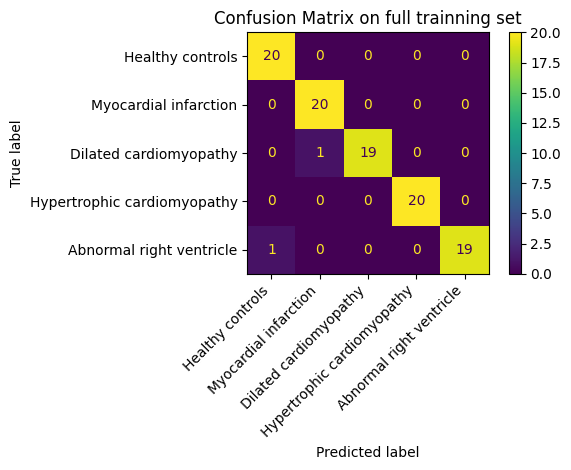

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      1.00      0.98        20
           2       1.00      0.95      0.97        20
           3       1.00      1.00      1.00        20
           4       1.00      0.95      0.97        20

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [74]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

class_names = {0 : "Healthy controls",
                1: "Myocardial infarction",
                2: "Dilated cardiomyopathy",
                3: "Hypertrophic cardiomyopathy",
                4 : "Abnormal right ventricle"
}
labels = sorted(class_names.keys())
y_pred = inf_pipeline.predict(X_train)

disp = ConfusionMatrixDisplay.from_predictions(
    y["Category"], y_pred,
    display_labels=[class_names[i] for i in labels],     
)
disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=45, ha='right')
disp.ax_.set_title("Confusion Matrix on full trainning set")
plt.tight_layout()
plt.savefig("conf_matrix_svm_sfe.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

print(classification_report(y_train,y_pred))

In [75]:
# Get the probabilities to get better insight on the model performance

proba = inf_pipeline.predict_proba(X_train)
print(f"average entropy score : {np.mean(certainty_score(proba))}")
print(f"\naverage margin score : {np.mean(margin_score(proba))}\n")
# Below 
treshold = 0.4
L = [0,0,0,0,0]
for x in proba : 
    a= 0
    index = []
    for ind,i in enumerate(x) :
        if i > treshold : 
            a+=1
            index.append(ind)
    if a >=2 : 
        for j in index : 
            L[j] +=1  
#print(proba)  
print(L)

average entropy score : 0.6253196332996978

average margin score : 0.7161262016259154

[1, 0, 0, 1, 0]


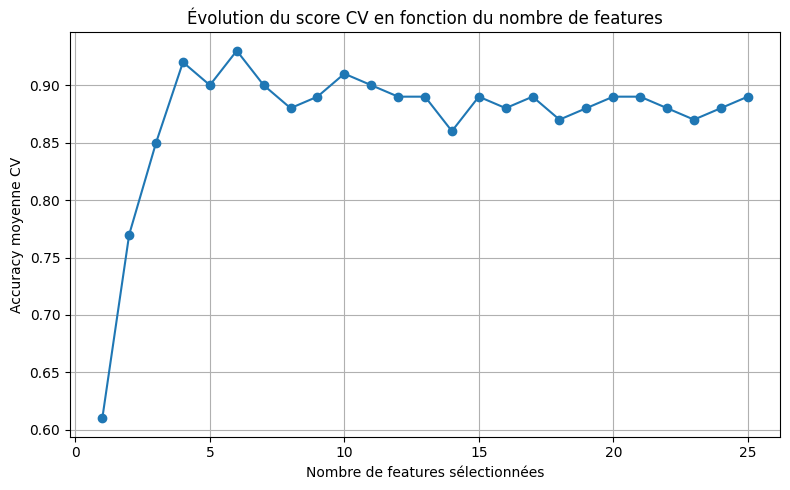

In [76]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# 1) Paramètres
max_feats = 25
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

# 2) Boucle sur le nombre de features
for k in range(1, max_feats + 1):
    # on recrée un SFS pour k variables
    sfs_k = SequentialFeatureSelector(
        estimator=base_clf,
        n_features_to_select=k,
        direction="forward",
        scoring=make_scorer(accuracy_score),
        cv=cv,
        n_jobs=-1
    )
    # pipeline identique, juste la SFS qui change
    pipe_k = ImbPipeline([
        ("normaliser", StandardScaler()),
        ("feature_selection", sfs_k),
        ("classifier", SVC(**{ 
            # utilisez ici vos meilleurs hyper-paramètres
            "C": best_params["classifier__C"],
            "gamma": best_params["classifier__gamma"],
        }))
    ])
    # évaluer par CV
    cv_scores = cross_val_score(pipe_k, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    scores.append(cv_scores.mean())

# 3) Tracé
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_feats + 1), scores, marker="o")
plt.xlabel("Nombre de features sélectionnées")
plt.ylabel("Accuracy moyenne CV")
plt.title("Évolution du score CV en fonction du nombre de features")
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_nb_f_svm_sfe.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()


In [77]:
### MIXTURE 